# Setup

In [1]:
from proxmox.dict import proxmox_nodes
from proxmox.docs import _proxmox_api_docs
from proxmox.base import ProxmoxAPIChain
from langchain.text_splitter import RecursiveJsonSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.vectorstores.surrealdb import SurrealDBStore
from langchain_huggingface import HuggingFaceEmbeddings
import nest_asyncio
import os
import hvac
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm, trange
import torch
import getpass

C:\Users\oumay\AppData\Local\Temp\ipykernel_11960\3794227179.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Load environment variables from .env file
load_dotenv()

True

In [3]:
def get_vault_token():
    token = os.getenv('VAULT_TOKEN')
    if not token:
        os.environ['VAULT_TOKEN'] = getpass.getpass(f"Please provide your Vault token:").strip()
    return os.environ['VAULT_TOKEN']

# Function to access the secret from Vault
def access_vault_secret(vault_token, url, secret_path):
    try:
        client = hvac.Client(url=url, token=vault_token)
        response = client.secrets.kv.v2.read_secret_version(path=secret_path, mount_point="kv" , raise_on_deleted_version=True)
        if response:
            secret_data = response['data']['data']
            print(f"Accessed Vault secret at {secret_path}.")
            return secret_data
        else:
            print(f"Failed to access Vault secret at {secret_path}.")
            return None
    except hvac.exceptions.VaultError as e:
        print(f"Request to Vault failed: {e}")
        return None

vault_token = get_vault_token()

# Retrieve Vault URL from environment variables
vault_url = os.getenv('VAULT_URL')

# Paths to secrets in Vault
#proxmox_secret_path = "users/accounts/api-tokens/proxmox/oumaima"
surrealdb_url_path = "users/accounts/surrealdb"
surrealdb_credentials_path = "users/accounts/surrealdb/oumaima"

# Access SurrealDB URL from Vault
surrealdb_url_secret = access_vault_secret(vault_token, vault_url, surrealdb_url_path)
if surrealdb_url_secret:
    os.environ['SURREALDB_URL'] = surrealdb_url_secret.get('url')
else:
    print("Failed to retrieve SurrealDB URL.")

# Access SurrealDB credentials from Vault
surrealdb_credentials_secret = access_vault_secret(vault_token, vault_url, surrealdb_credentials_path)
if surrealdb_credentials_secret:
    os.environ['SURREALDB_USER'] = surrealdb_credentials_secret.get('user')
    os.environ['SURREALDB_PWD'] = surrealdb_credentials_secret.get('password')
else:
    print("Failed to retrieve SurrealDB credentials.")

Request to Vault failed: 2 errors occurred:
	* permission denied
	* invalid token

, on get http://46.105.247.55:8200/v1/kv/data/users/accounts/surrealdb
Failed to retrieve SurrealDB URL.
Request to Vault failed: 2 errors occurred:
	* permission denied
	* invalid token

, on get http://46.105.247.55:8200/v1/kv/data/users/accounts/surrealdb/oumaima
Failed to retrieve SurrealDB credentials.


In [4]:
proxmox_HCM_api_token = os.getenv('PROXMOX_HCM_API_TOKEN') 
node5_api_token = os.getenv('NODE_5_API_TOKEN')
surrealdb_url = os.getenv('SURREALDB_URL')
surrealdb_user = os.getenv('SURREALDB_USER')
surrealdb_password = os.getenv('SURREALDB_PWD')

In [5]:
splitter = RecursiveJsonSplitter(max_chunk_size=4000)
docs = splitter.create_documents(_proxmox_api_docs)

In [6]:
# Initialize the SentenceTransformerEmbeddings with trust_remote_code=True
ef = HuggingFaceEmbeddings(
    model_name="infgrad/stella_en_400M_v5",
    model_kwargs={
        "trust_remote_code": True,
    }
)

c:\Users\oumay\.vscode\agent-scripts\venv\Lib\site-packages\xformers\ops\fmha\flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
c:\Users\oumay\.vscode\agent-scripts\venv\Lib\site-packages\xformers\ops\fmha\flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Some weights of the model checkpoint at infgrad/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initial

In [7]:
nest_asyncio.apply()

# SurrealDB connection parameters
dburl = "ws://localhost:8000/rpc"
ns = "langchain"
db_name = "proxmox_api_docs"
collection = "proxmox_collection"
db_user = surrealdb_user
db_pass = surrealdb_password

# Initialize the SurrealDBStore with documents
db = SurrealDBStore(
    embedding_function=ef,
    dburl=dburl,
    ns=ns,
    db=db_name,
    collection=collection,
    db_user=db_user,
    db_pass=db_pass
)


# this is needed to initialize the underlying async library for SurrealDB
await db.initialize()

# delete collection from the vectorstore collection if it exists 
await db.adelete(collection = collection)

# add documents to the vectorstore
ids = await db.aadd_documents(docs)

retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# Initialize the cross-encoder model
#cross_encoder_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
cross_encoder_model = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")
compressor = CrossEncoderReranker(model=cross_encoder_model, top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

# Team approach

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama

# Define the prompt template
prompt = PromptTemplate(
    template=("""
    You are a supervisor tasked with routing a query to one of the following workers: {workers}. 
    Given the following user request, respond with the worker to act next. Each worker will perform a task 
    and respond with their results and status. The worker output will be returned to the user. 
    The options for workers are {workers}. Return 'end' if the request isn't related to any of the given workers.

    User request: {question}

    Respond in JSON format with a single key "next" which holds the worker name.

    next :
    """),
    input_variables=["question"],
    partial_variables={"workers": list(proxmox_nodes.keys())}
)

# Initialize the LLM
llm_sup = ChatOllama(model="phi3", temperature=0, format="json")
#llm_sup = ChatOllama(model="llama3.1", temperature=0, format="json")


# Combine prompt and LLM with JsonOutputParser
sup_chain = prompt | llm_sup | JsonOutputParser()


In [9]:
sup_chain.invoke({
    "question": "How many Vms on node Proxmox-Node-HCM",
})

{'next': 'Proxmox-Node-HCM'}

In [10]:
from langchain_core.messages import BaseMessage
import operator
from typing import Annotated, List, TypedDict, Literal


class ProxmoxTeamState(TypedDict):
    messages: List[BaseMessage]
    team_members: List[str]
    next: str

In [11]:
def supervisor(state: ProxmoxTeamState) -> ProxmoxTeamState:
    print(f"processing_request: Current state: {state}")
    question = state["messages"][0]
    result = sup_chain.invoke({"question": question})
    state["next"] = result["next"]
    state["team_members"] = list(proxmox_nodes.keys())
    return state

In [12]:
initial_state = {
            "messages": ["list Vms on node 'Proxmox-Node-HCM'"],
            "next": None,
            "team_members": []
        }
supervisor(initial_state)

processing_request: Current state: {'messages': ["list Vms on node 'Proxmox-Node-HCM'"], 'next': None, 'team_members': []}


{'messages': ["list Vms on node 'Proxmox-Node-HCM'"],
 'next': 'Proxmox-Node-HCM',
 'team_members': ['Proxmox-Node-HCM', 'ns31212248']}

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the llm with the new model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0)

In [14]:
# Initialize the LLM
#llm = ChatOllama(model="llama3.1", temperature=0, format="json")

In [ ]:
proxmox_nodes.keys()

In [15]:
agents = {}

for node_name, node_info in proxmox_nodes.items():
    chain = ProxmoxAPIChain.from_llm_and_api_docs(
        llm,
        retriever=compression_retriever,
        headers={"Authorization": node_info['api_token']},
        pve_token=node_info['api_token'],
        verbose=True,
        limit_to_domains=[node_info["base_url"]],
        base_url=node_info["base_url"],
    )
    agents[node_name] = chain

In [16]:
result = agents["Proxmox-Node-HCM"].invoke(("list Vms on node 'Proxmox-Node-HCM'"))
print(result)



> Entering new ProxmoxAPIChain chain...


c:\Users\oumay\.vscode\agent-scripts\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu/{vmid}/config", "method": "get", "summary": "Get Virtual machine/Vm Configuration (config file)", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM is located", "schema": {"type": "string"}}, {"name": "vmid", "in": "path", "required": true, "description": "ID of the VM", "schema": {"type": "integer"}}, {"name": "current", "in": "query", "required": false, "description": "Get current values instead of pending values", "schema": {"type": "boolean"}}]}
Retrieved Document 2: {"endpoint": "/api2/json/nodes/{node}/lxc", "methods": "get", "summary": "List LXC Containers on a Node", "description": "List a

In [17]:
def Worker_node(state: ProxmoxTeamState, node_name: str) -> ProxmoxTeamState:
    print(f"{state['next']} / {node_name}")
    question = state["messages"][0]
    result = agents[node_name].invoke(input=question)
    state["messages"].append(result)
    return state

In [18]:
state = {
    "next": "Proxmox-Node-HCM",
    "messages": ["How many Vms on node Proxmox-Node-HCM?"]
}

# Test with node5
new_state = Worker_node(state, "Proxmox-Node-HCM")
print(new_state)  # Output should show the updated state with the "Node5 response" appended


Proxmox-Node-HCM / Proxmox-Node-HCM


> Entering new ProxmoxAPIChain chain...
Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "post", "summary": "Create a Virtual machine (VM) ", "description": "Use this endpoint to create a new virtual machine on the specified node. This endpoint is used for initial creation and can be used for the allocation of resources such as memory, cores, and storage.", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM will be created", "schema": {"type": "string"}}], "requestBody": {"required": true, "content": {"application/json": {"schema": {"type": "object", "properties": {"vmid": {"type": "integer", "des

In [19]:
from typing import Literal

def proxmox_router(state: ProxmoxTeamState) :
    next_worker = state["next"]
    print(f"proxmox_router: Current state: {state}")
    if next_worker in proxmox_nodes.keys():
        return next_worker
    return "end"

In [20]:
state = {"next": "Proxmox-Node-HCM"}
result = proxmox_router(state)
print(result) 

proxmox_router: Current state: {'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM


In [21]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

proxmox_graph = StateGraph(ProxmoxTeamState)

for node_name, node_info in proxmox_nodes.items():
    proxmox_graph.add_node(node_name, lambda state, node_name=node_name: Worker_node(state, node_name))
    proxmox_graph.add_edge(node_name, END)

proxmox_graph.add_node("supervisor", supervisor)

proxmox_graph.add_conditional_edges(
    "supervisor",
    proxmox_router,
    {node_name: node_name for node_name in proxmox_nodes.keys()}
)

proxmox_graph.add_edge(START, "supervisor")
chain = proxmox_graph.compile()

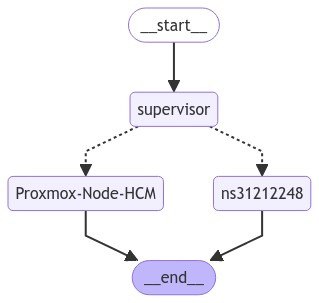

In [22]:
display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [23]:
from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler(
    public_key=os.getenv('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.getenv('LANGFUSE_SECRET_KEY'),
    host=os.getenv('LANGFUSE_HOST'),
)

In [24]:
chain.invoke({
            "messages": ["list Vms on node 'Proxmox-Node-HCM'"],
            "next": None,
            "team_members": []
        }, config={"callbacks": [langfuse_handler]})

processing_request: Current state: {'messages': ["list Vms on node 'Proxmox-Node-HCM'"], 'team_members': [], 'next': None}
proxmox_router: Current state: {'messages': ["list Vms on node 'Proxmox-Node-HCM'"], 'team_members': ['Proxmox-Node-HCM', 'ns31212248'], 'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM / Proxmox-Node-HCM


> Entering new ProxmoxAPIChain chain...
Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu/{vmid}/config", "method": "get", "summary": "Get Virtual machine/Vm Configuration (config file)", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM is located", "schema": {"type": "string"}}, {"name": "vmid", "in": "path", "required": tru

{'messages': ["list Vms on node 'Proxmox-Node-HCM'",
  {'question': "list Vms on node 'Proxmox-Node-HCM'",
   'output': "The VMs on the node 'Proxmox-Node-HCM' are: my-vm, primary-test, PgSQL-IMX, PgSQL-IMX-Replicaset, Ansible-controller, SurrealDB-IMX, Mongo-IMX, test-vm, VM 10001, test-vault01, NewRelic-GitLab, PgSQL-Primary, VM 10002, VM 10004, and test-mfa. \n"}],
 'team_members': ['Proxmox-Node-HCM', 'ns31212248'],
 'next': 'Proxmox-Node-HCM'}